# **Credit Card Fraud Analysis**
---
# **Author:** Priyanka Lakra
# **Tools:** Python, Pandas, NumPy, Matplotlib, Seaborn, SMOTE, XGBoost, Joblib


# **0. Imports & Settings**


In [181]:
import os
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (confusion_matrix, f1_score, precision_score,
                             precision_recall_curve, recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

# Reproducibility
RANDOM_STATE = 42



# **1. Output folders**


In [182]:
BASE_DIR = Path(".")
OUT_DIR = BASE_DIR / "outputs"
PLOTS_DIR = OUT_DIR / "plots"
CSV_DIR = OUT_DIR / "csv"
MODEL_DIR = OUT_DIR / "model"

for d in [OUT_DIR, PLOTS_DIR, CSV_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)





# **2. Load Data**


In [183]:

raw = pd.read_csv("creditcard.csv")


In [184]:
df = raw.copy()


In [185]:

print("Dataset shape:", df.shape)

Dataset shape: (284807, 31)


In [186]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [187]:
print("Missing values per column:\n", df.isnull().sum().sum(), "(total)\n")


Missing values per column:
 0 (total)



In [188]:

duplicates = df.duplicated().sum()
print("Duplicates:", duplicates)


Duplicates: 1081


In [189]:
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates. New shape:", df.shape)


Dropped duplicates. New shape: (283726, 31)


In [190]:

print("Class distribution:\n", df["Class"].value_counts())


Class distribution:
 Class
0    283253
1       473
Name: count, dtype: int64


In [191]:
percentages = df["Class"].value_counts(normalize=True) * 100
print(percentages)

Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64


- dataset is clean, consistent, and ready for modeling — ideal for fraud analysis
- Fraud cases ≈ 0.17% vs Non-Fraud ≈ 99.83%,highly imbalanced dataset 

# **3. Feature Engineering & Scaling**


In [192]:
# Create scaled amount and scaled time using separate scalers
scaler_amount = StandardScaler()
scaler_time = StandardScaler()

# Keep original Amount and Time in `raw` for KPIs
df["scaled_amount"] = scaler_amount.fit_transform(df[["Amount"]]).ravel()

# Scale Time and add Hour feature
df["scaled_time"] = scaler_time.fit_transform(df[["Time"]]).ravel()
df["Hour"] = ((df["Time"] // 3600) % 24).astype(int)

In [193]:

# Save scalers for later use
joblib.dump(scaler_amount, MODEL_DIR / "scaler_amount.joblib")
joblib.dump(scaler_time, MODEL_DIR / "scaler_time.joblib")


['outputs\\model\\scaler_time.joblib']

# **4. Exploratory Data Analysis**


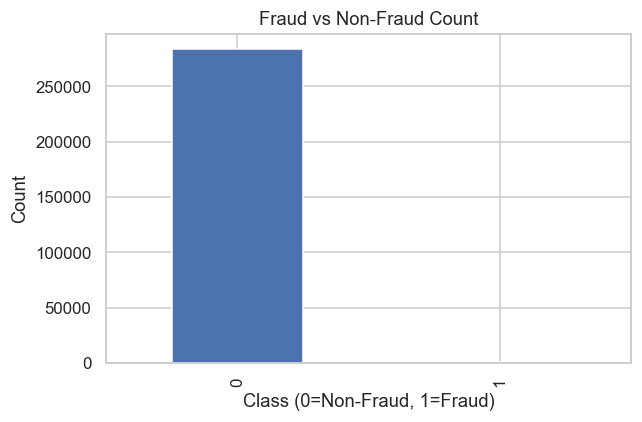

In [194]:
# Class distribution
plt.figure(figsize=(6,4))
df["Class"].value_counts().plot(kind="bar")
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("Class (0=Non-Fraud, 1=Fraud)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "class_distribution.png")
plt.show()


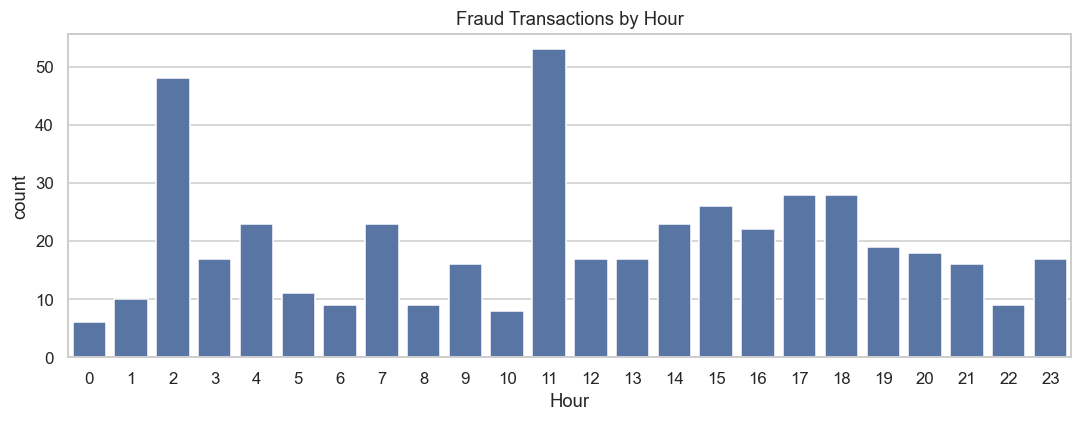

In [195]:


# Fraud by hour
plt.figure(figsize=(10,4))
sns.countplot(data=df[df.Class == 1], x="Hour")
plt.title("Fraud Transactions by Hour")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "fraud_by_hour.png")
plt.show()

- Fraudsters pick low-activity windows:

- 2 AM → customers sleeping

- 11 AM peak → busy business hours (high volume hides fraud)

- Evening 5–6 PM → high user traffic = disguised fraud

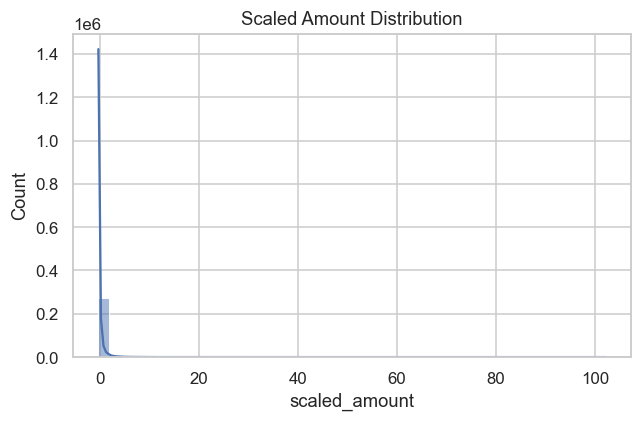

In [196]:


# Scaled amount distribution
plt.figure(figsize=(6,4))
sns.histplot(df["scaled_amount"], bins=50, kde=True)
plt.title("Scaled Amount Distribution")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "scaled_amount_dist.png")
plt.show()


- Fraudsters commonly do small ‘test’ transactions

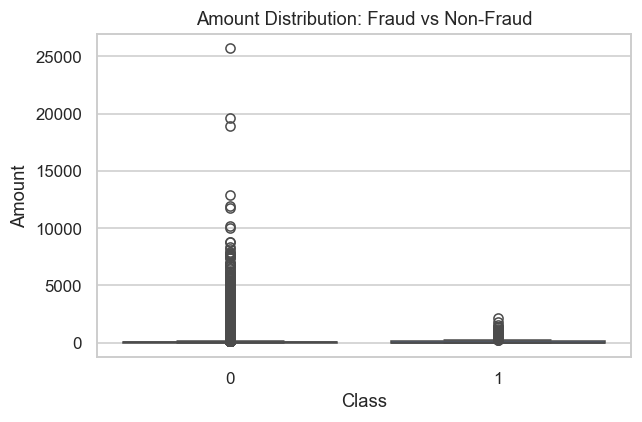

In [197]:


# Amount vs Class boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x="Class", y="Amount", data=raw)
plt.title("Amount Distribution: Fraud vs Non-Fraud")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "amount_fraud_boxplot.png")
plt.show()

- Fraud amounts are more clustered (less diverse)

- Non-fraud has extreme high-value outliers (normal business spending)

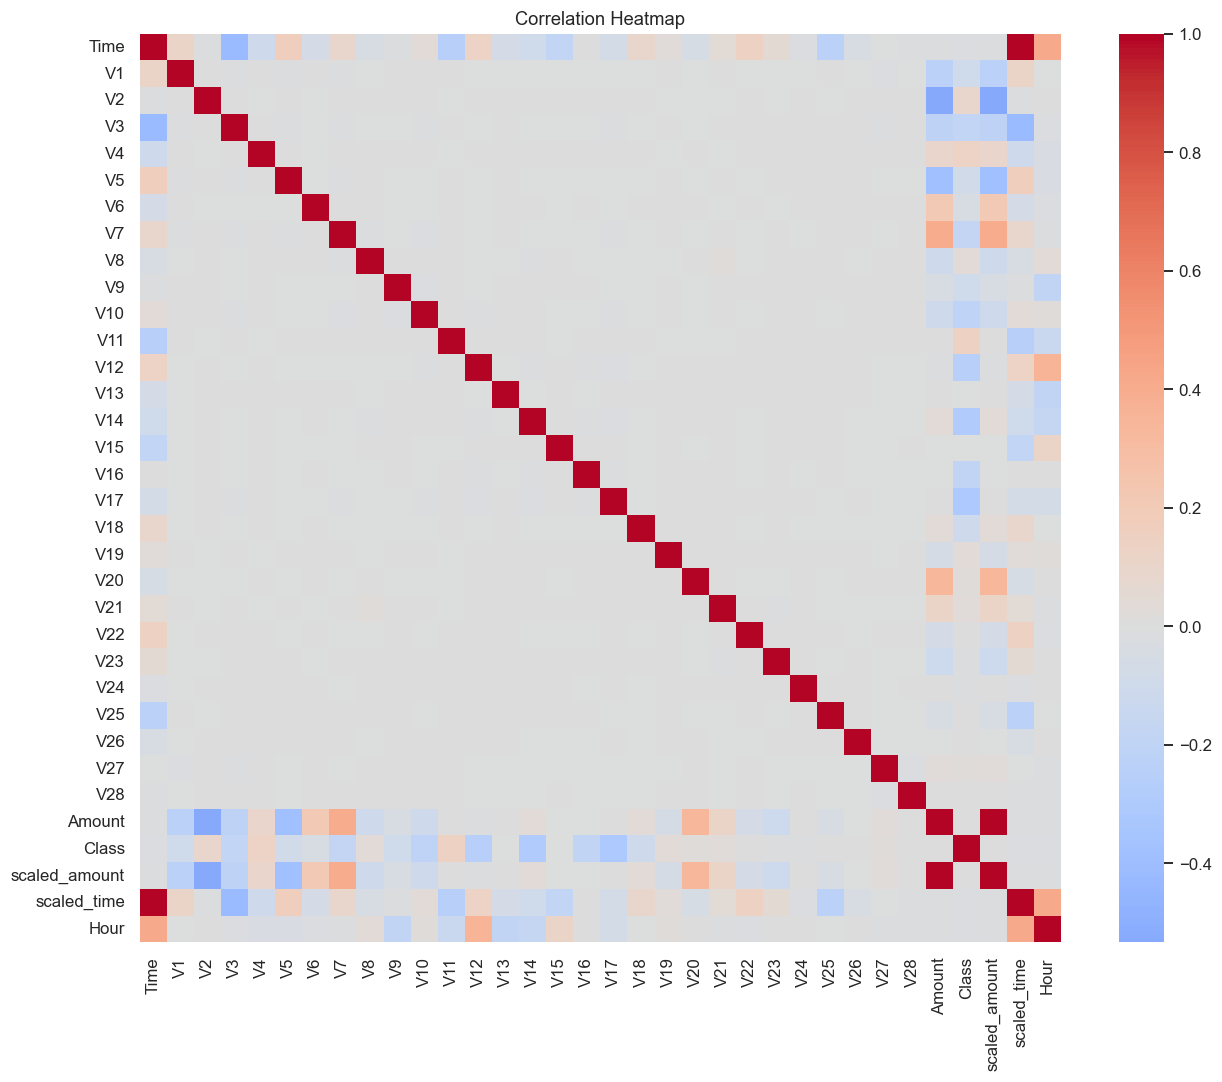

In [198]:


# Correlation heatmap 
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "correlation_heatmap.png")
plt.show()

- Each PCA feature captures a unique behavioural pattern, not redundant info.
- Fraud has distinct patterns with time and amount.


In [199]:


# Export EDA summary CSV 
eda_summary = pd.DataFrame({
    "metric": ["total_transactions", "fraud_transactions", "fraud_ratio"],
    "value": [len(df), df.Class.sum(), df.Class.mean()]
})
eda_summary.to_csv(CSV_DIR / "eda_summary.csv", index=False)


Key Insights From Fraud EDA

- Fraud spikes happen during late-night (2 AM) and midday (11–12 PM) indicating fraudsters exploit quiet hours and busy hours.

- Transaction amounts are highly skewed, showing most customers make small purchases while fraud contains both very small “test” transactions and sudden mid-value attacks.

- Fraud transactions cluster tightly in amount distribution, unlike normal users who show diverse spending (including legitimate high-value outliers).

- Correlation matrix shows PCA components (V1–V28) hold unique behavioural patterns, proving ML is needed instead of rule-based checks.

- Hour and Amount features show meaningful behaviour with fraud, justifying your feature engineering.

- Class has low correlation with all features, confirming fraud patterns are hidden and require anomaly detection.


# **5. Prepare Data for Modeling**


In [200]:

# Ensure column ordering and presence
feature_columns = [c for c in df.columns if c.startswith("V")]
additional = ["scaled_amount", "scaled_time", "Hour"]

# Final feature set
X = df[feature_columns + additional]
y = df["Class"].astype(int)

print("Feature set shape:", X.shape)


Feature set shape: (283726, 31)


In [201]:

# Train-test split stratified to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

# Save test set for Power BI / auditing
X_test_export = X_test.copy()
X_test_export["Actual_Class"] = y_test.values
X_test_export.to_csv(CSV_DIR / "X_test_with_actual.csv", index=False)



# **6. Smote — Handle Imbalance**


In [202]:
print("Before SMOTE class counts:\n", y_train.value_counts())


Before SMOTE class counts:
 Class
0    212439
1       355
Name: count, dtype: int64


In [203]:

sm = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("After SMOTE class counts:\n", y_train_bal.value_counts())


After SMOTE class counts:
 Class
0    212439
1    212439
Name: count, dtype: int64


In [204]:

# Export balanced training data for audit
train_balanced = pd.concat([X_train_bal.reset_index(drop=True), y_train_bal.reset_index(drop=True)], axis=1)
train_balanced.to_csv(CSV_DIR / "train_balanced.csv", index=False)



# **7. Model Building — XGBoost**


In [205]:
# XGBoost model
model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=RANDOM_STATE,
)

model.fit(X_train_bal, y_train_bal)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [206]:

# Save model
joblib.dump(model, MODEL_DIR / "xgb_fraud_model.joblib")


['outputs\\model\\xgb_fraud_model.joblib']


# **8. Default Threshold Predictions**


In [207]:
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)


In [208]:


precision_def = precision_score(y_test, y_pred_default, zero_division=0)
recall_def = recall_score(y_test, y_pred_default, zero_division=0)
f1_def = f1_score(y_test, y_pred_default, zero_division=0)
roc_def = roc_auc_score(y_test, y_proba)
cm_def = confusion_matrix(y_test, y_pred_default)

In [209]:
print("Default threshold results:")
print(precision_def, recall_def, f1_def, roc_def)
print(cm_def)

Default threshold results:
0.28 0.8305084745762712 0.4188034188034188 0.9816785486734645
[[70562   252]
 [   20    98]]


In [210]:
pd.DataFrame(cm_def, columns=["Pred_0","Pred_1"], index=["Actual_0","Actual_1"]).to_csv(CSV_DIR / "confusion_matrix_default.csv")

# **9. Threshold Tuning**


In [211]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# If thresholds is empty (edge case), fall back to 0.5
if len(thresholds) == 0:
    best_threshold = 0.5
else:
    # heuristic: maximize (recall - (1 - precision))
    scores = recalls - (1 - precisions)
    # scores length = len(thresholds) + 1, so exclude last sentinel
    best_idx = np.argmax(scores[:-1])
    best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)


Best threshold: 0.98355615


In [212]:

y_pred_opt = (y_proba >= best_threshold).astype(int)



In [213]:

precision_opt = precision_score(y_test, y_pred_opt, zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, zero_division=0)
f1_opt = f1_score(y_test, y_pred_opt, zero_division=0)
roc_opt = roc_auc_score(y_test, y_proba)
cm_opt = confusion_matrix(y_test, y_pred_opt)



In [214]:

pd.DataFrame(cm_opt, columns=["Pred_0","Pred_1"], index=["Actual_0","Actual_1"]).to_csv(CSV_DIR / "confusion_matrix_optimized.csv")


# **10. Feature Importance —(XGBoost)**


In [215]:
importance = model.feature_importances_
fi_df = pd.DataFrame({
"feature": X_train.columns,
"importance": importance
}).sort_values("importance", ascending=False)


fi_df.to_csv(CSV_DIR / "feature_importance_gain.csv", index=False)



In [216]:
assert len(importance) == len(X_train.columns), "Feature importances length mismatch!"


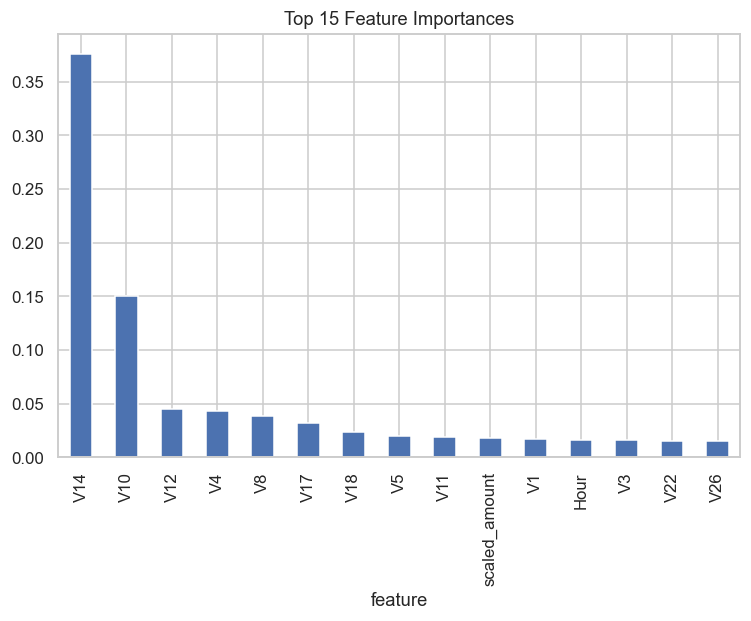

In [217]:

plt.figure(figsize=(8,5))
fi_df.head(15).set_index("feature")["importance"].plot(kind="bar")
plt.title("Top 15 Feature Importances")
plt.show()



# **11. Exports for Power BI & Reporting**


In [218]:
test_export = X_test.copy()
test_export["Actual"] = y_test
test_export["Predicted_default"] = y_pred_default
test_export["Predicted_opt"] = y_pred_opt
test_export["Probability"] = y_proba


test_export.to_csv(CSV_DIR / "test_predictions.csv", index=False)

In [219]:

# Global KPIs
total_transactions = len(y_test)
fraud_transactions = int(y_test.sum())


In [220]:
# Calculate fraud loss from raw DF based on original test indices
raw_test = raw.loc[X_test.index]  
fraud_loss = raw_test.loc[raw_test["Class"] == 1, "Amount"].sum()


In [221]:
kpi_df = pd.DataFrame({
    "precision_opt": [precision_opt],
    "recall_opt": [recall_opt],
    "f1_opt": [f1_opt],
    "roc_auc": [roc_opt],
    "total_transactions": [total_transactions],
    "fraud_transactions": [fraud_transactions],
    "estimated_fraud_loss_in_test_set": [fraud_loss]
})

In [222]:
kpi_df.to_csv(CSV_DIR / "global_kpis.csv", index=False)


In [223]:

# Save predicted probabilities and indexes for audit
pd.DataFrame({
    "index": X_test.index,
    "actual": y_test.values,
    "pred_opt": y_pred_opt,
    "prob": y_proba
}).to_csv(CSV_DIR / "test_probs_indexed.csv", index=False)



# **12. Save final artifacts**


In [224]:
joblib.dump(model, MODEL_DIR / "xgb_fraud_model_final.joblib")
joblib.dump(scaler_amount, MODEL_DIR / "scaler_amount.joblib")
joblib.dump(scaler_time, MODEL_DIR / "scaler_time.joblib")

['outputs\\model\\scaler_time.joblib']

In [225]:

print("Artifacts saved to:", OUT_DIR)


Artifacts saved to: outputs
